Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

Load and preprocess data

In [2]:
df = pd.read_csv('synthetic_data_final.csv')
df = df.dropna()
df["Date"] = pd.to_datetime(df["Date"])

Feature Engineering

In [3]:
df["Base_Working_Time"] = df["Effective_Running_Time"] + df['Ancillary_Time'] + df['Internal_Downtime'] + df['External_Downtime']
df["MME"] = df["General_Running_Time"] / df["Effective_Running_Time"]
df["Q"] = 1 - (df["Waste_Packages"] / (df["Waste_Packages"] + df["Good_Packages"]))  # Quality
df["P"] = 1 - ((df["Nominal_Speed"] - df["Actual_Speed"]) / df["Nominal_Speed"])  # Performance
df["A"] = 1 - ((df["Ancillary_Time"] + df["Internal_Downtime"] + df["External_Downtime"]) / df["Base_Working_Time"])  # Availability
df["OEE"] = df["Q"] * df["P"] * df["A"]

Defining Targets and Features

In [4]:
X = df.drop(columns=["OEE", "Date", "MME"])
y = df[["MME", "OEE"]]

Splitting data for training and testing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale data

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Reshape for GRU Input

In [7]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

Build the GRU Model

In [8]:
input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
gru_layer = GRU(units=100, return_sequences=True)(input_layer)
gru_layer = Dropout(0.3)(gru_layer)
gru_layer = GRU(units=100)(gru_layer)
gru_layer = Dropout(0.3)(gru_layer)

In [9]:
output_mme = Dense(1, name='mme_output')(gru_layer)
output_oee = Dense(1, name='oee_output')(gru_layer)

model = Model(inputs=input_layer, outputs=[output_mme, output_oee])

Compile the model

In [10]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

Callbacks

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

Train the Model

In [12]:
history = model.fit(X_train_scaled, {'mme_output': y_train['MME'], 'oee_output': y_train['OEE']}, 
                    epochs=100, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
11/11 [==============================] - 6s 130ms/step - loss: 1.8836 - mme_output_loss: 1.5014 - oee_output_loss: 0.3822 - val_loss: 1.6841 - val_mme_output_loss: 1.3394 - val_oee_output_loss: 0.3448 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3663 - mme_output_loss: 1.0734 - oee_output_loss: 0.2928 - val_loss: 1.1371 - val_mme_output_loss: 0.8976 - val_oee_output_loss: 0.2395 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7749 - mme_output_loss: 0.6103 - oee_output_loss: 0.1646 - val_loss: 0.5203 - val_mme_output_loss: 0.4075 - val_oee_output_loss: 0.1128 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2690 - mme_output_loss: 0.2076 - oee_output_loss: 0.0614 - val_loss: 0.0610 - val_mme_output_loss: 0.0466 - val_oee_output_loss: 0.0144 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0985 - mme_output_loss: 0.

Predict and Evaluate

In [13]:
y_pred = model.predict(X_test_scaled)
y_pred_mme = y_pred[0].flatten()
y_pred_oee = y_pred[1].flatten()

4/4 [==============================] - 1s 7ms/step


In [14]:
mse_mme = mean_squared_error(y_test['MME'], y_pred_mme)
mae_mme = mean_absolute_error(y_test['MME'], y_pred_mme)
rmse_mme = np.sqrt(mse_mme)

mse_oee = mean_squared_error(y_test['OEE'], y_pred_oee)
mae_oee = mean_absolute_error(y_test['OEE'], y_pred_oee)
rmse_oee = np.sqrt(mse_oee)

In [15]:
#print(f'MME - MAE: {mae_mme}')
#print(f'MME - MSE: {mse_mme}')
print(f'MME - RMSE: {rmse_mme}')
#print(f'OEE - MAE: {mae_oee}')
#print(f'OEE - MSE: {mse_oee}')
print(f'OEE - RMSE: {rmse_oee}')

MME - RMSE: 0.02619306329319695
OEE - RMSE: 0.0135141501250852


Plotting Actual vs Predicted OEE

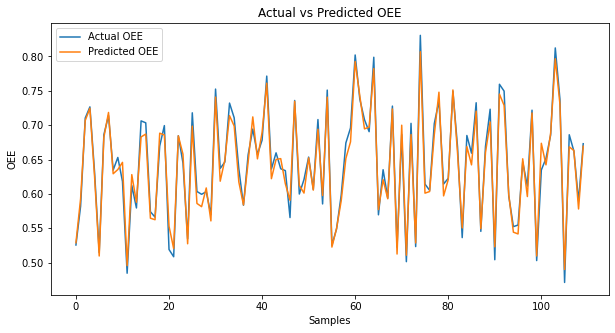

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(y_test['OEE'].values, label='Actual OEE')
plt.plot(y_pred_oee, label='Predicted OEE')
plt.title('Actual vs Predicted OEE')
plt.xlabel('Samples')
plt.ylabel('OEE')
plt.legend()
plt.show()

Plotting Actual vs Predicted MME

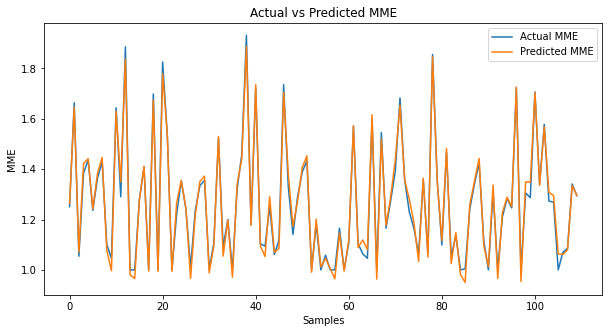

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(y_test['MME'].values, label='Actual MME')
plt.plot(y_pred_mme, label='Predicted MME')
plt.title('Actual vs Predicted MME')
plt.xlabel('Samples')
plt.ylabel('MME')
plt.legend()
plt.show()